# Neural Network Implementation from Scratch

# IMPORTING DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown --id 1Atr7OtXR2osUUcyOhlTB05n-dHmaZu0I   # mnist_test.csv
!gdown --id 1rpOFGPZVrp1_05R7lSvijFnAOxaMFPxP    # mnist_train.csv

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Atr7OtXR2osUUcyOhlTB05n-dHmaZu0I
To: /content/mnist_test.csv
100% 18.3M/18.3M [00:00<00:00, 87.8MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rpOFGPZVrp1_05R7lSvijFnAOxaMFPxP
To: /content/mnist_train.csv
100% 110M/110M [00:01<00:00, 72.2MB/s] 


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# BUILING LAYERS CLASS

In [ ]:
class Layer:
    def __init__(self, nodes_in, nodes_out, activation):
        self.nodes_in = nodes_in
        self.nodes_out = nodes_out
        self.activation = activation

        self.prev_layer = None
        self.next_layer = None
        self.input = None
        self.output = None

        self.weights = np.random.rand(self.nodes_out, self.nodes_in) - 0.5
        self.biases = np.random.rand(self.nodes_out, 1) - 0.5

    def forward(self, input):
        self.Z = self.weights.dot(input) + self.biases
        self.A = activation_functions(self.Z, False, self.activation)
        self.output = self.A

        if self.next_layer: self.next_layer.input = self.output
        return self.output

    def backward(self, lr, output_error, one_hot_Y=None):
        if self.next_layer == None:
            output_error = self.A - one_hot_Y
            dZ = output_error
        else:
            dA = self.next_layer.weights.T.dot(output_error)
            dZ = dA * activation_functions(self.Z, True, self.activation)

        # Finding gradient wrt weights and biases
        self.dW = (1 / self.A.shape[1]) * dZ.dot(self.input.T)
        self.db = (1 / self.A.shape[1]) * np.sum(dZ)

        # Updating weights and biases
        self.weights -= lr * self.dW
        self.biases -= lr * self.db

        return dZ


# BUILING NEURAL NETWORK CLASS

In [ ]:
class NeuralNetwork:
    def __init__(self):
        self.layers = []

    def add_layer(self, layer):
        self.layers.append(layer)
        if len(self.layers) > 1:
            self.layers[-2].next_layer = self.layers[-1]
            self.layers[-1].prev_layer = self.layers[-2]

    def forward_prop(self, input, i=0):
        if self.layers[i].next_layer == None:
            return self.layers[i].forward(input)
        return self.forward_prop(self.layers[i].forward(input), i+1)

    def backward_prop(self, lr, Y):
        dZ = 0
        for i in self.layers[::-1]:
            if i.next_layer==None:
                one_hot_Y = one_hot(Y)
                dZ = i.backward(lr, dZ, one_hot_Y)
            else:
                dZ = i.backward(lr, dZ)

    def get_predictions(self):
        return np.argmax(self.layers[-1].A, 0)

    def get_accuracy(self, predictions, Y):
        return np.sum(predictions == Y) / Y.size

    def gradient_descent(self, X, Y, lr, iterations):
        for i in range(iterations):
            A_final = self.forward_prop(X)
            self.backward_prop(lr, Y)
            if i % 10 == 0:
                print("Iteration: ", i, end=', ')
                predictions = self.get_predictions()
                accuracy = self.get_accuracy(predictions, Y)
                print('Accuracy: ', round(accuracy*100, 2), end='%\n')

    def make_predictions(self, X):
        A_final = self.forward_prop(X)
        predictions = self.get_predictions()
        return predictions

    def test_prediction(self, index, X, Y):
        current_image = X[:, index, None]
        prediction = self.make_predictions(X[:, index, None])
        label = Y[:, index]
        print("Prediction: ", prediction)
        print("Label: ", label)

        current_image = current_image.reshape((28, 28)) * 255
        plt.gray()
        plt.imshow(current_image, interpolation='nearest')
        plt.show()

        return int((prediction == label)[0])

    def test_prediction_noprint(self, index, X, Y):
        current_image = X[:, index, None]
        prediction = self.make_predictions(X[:, index, None])
        label = Y[:, index]
        return int((prediction == label)[0])

# ACTIVATION FUNCTIONS + OTHERS

In [ ]:
def activation_functions(Z, deriv, activation):
    def relu(Z, deriv):
        if deriv:
            return Z > 0
        return np.maximum(Z, 0)

    def sigmoid(Z, deriv):
        if deriv:
            return sigmoid(Z, False) * (1 - sigmoid(Z, False))
        return 1/(1+np.exp(-Z))

    def softmax(Z, deriv):
        exps = np.exp(Z - Z.max())
        if deriv:
             return softmax(Z, False) * (1 - softmax(Z, False))
        return exps / np.sum(exps, axis=0)

    activation_outputs = {
        'relu': relu(Z, deriv),
        'sigmoid': sigmoid(Z, deriv),
        'softmax': softmax(Z, deriv)
    }
    return activation_outputs[f'{activation}']


def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

# LOADING DATA

In [ ]:
def load_data(path):
    data = pd.read_csv(f'{path}', delimiter=',')
    data = np.array(data)

    return (data[:, 1:] / 255.0).T, data[:, :1].T

X_train, Y_train = load_data('/content/mnist_train.csv')
n, m = X_train.shape

print(X_train.shape)
print(Y_train.shape)

X_test, Y_test = load_data('/content/mnist_test.csv')
print(X_test.shape)
print(Y_test.shape)

(784, 60000)
(1, 60000)
(784, 10000)
(1, 10000)


# BUILING ANN STRUCTURE

In [ ]:
layer1 = Layer(784, 32, 'relu')
layer2 = Layer(32, 10, 'softmax')
layer1.input = X_train

ann = NeuralNetwork()
ann.add_layer(layer1)
ann.add_layer(layer2)

ann.forward_prop(X_train)
ann.backward_prop(0.1, Y_train)

ann.gradient_descent(X_train, Y_train, lr=0.1, iterations=500)

Iteration:  0, Accuracy:  13.03%
Iteration:  10, Accuracy:  36.42%
Iteration:  20, Accuracy:  52.06%
Iteration:  30, Accuracy:  59.94%
Iteration:  40, Accuracy:  64.99%
Iteration:  50, Accuracy:  68.64%
Iteration:  60, Accuracy:  71.37%
Iteration:  70, Accuracy:  73.36%
Iteration:  80, Accuracy:  75.01%
Iteration:  90, Accuracy:  76.4%
Iteration:  100, Accuracy:  77.57%
Iteration:  110, Accuracy:  78.57%
Iteration:  120, Accuracy:  79.34%
Iteration:  130, Accuracy:  80.06%
Iteration:  140, Accuracy:  80.68%
Iteration:  150, Accuracy:  81.28%
Iteration:  160, Accuracy:  81.81%
Iteration:  170, Accuracy:  82.28%
Iteration:  180, Accuracy:  82.63%
Iteration:  190, Accuracy:  83.04%
Iteration:  200, Accuracy:  83.37%
Iteration:  210, Accuracy:  83.69%
Iteration:  220, Accuracy:  84.01%
Iteration:  230, Accuracy:  84.28%
Iteration:  240, Accuracy:  84.56%
Iteration:  250, Accuracy:  84.8%
Iteration:  260, Accuracy:  85.04%
Iteration:  270, Accuracy:  85.26%
Iteration:  280, Accuracy:  85.49

Thus, our model is decently trained with accuracy ~ 88%

# TESTING THE MODEL

In [ ]:
dev_predictions = ann.make_predictions(X_test)
accuracy = ann.get_accuracy(dev_predictions, Y_test)
print('Accuracy: ', round(accuracy*100, 2), '%')

Accuracy:  88.71 %


As the accuracy on testing data does not deviate much from accuracy on training data, we can say that the model is not over-fitted.

Prediction:  [8]
Label:  [8]


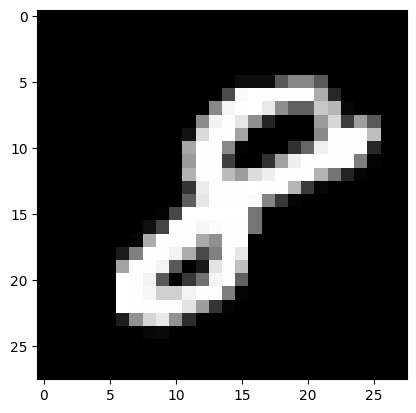

Prediction:  [2]
Label:  [2]


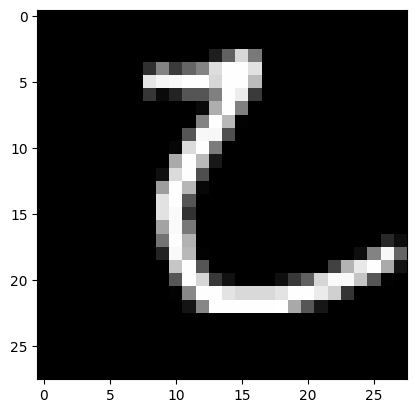

Prediction:  [5]
Label:  [8]


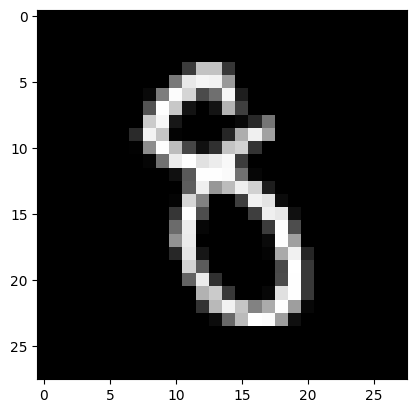

Prediction:  [0]
Label:  [0]


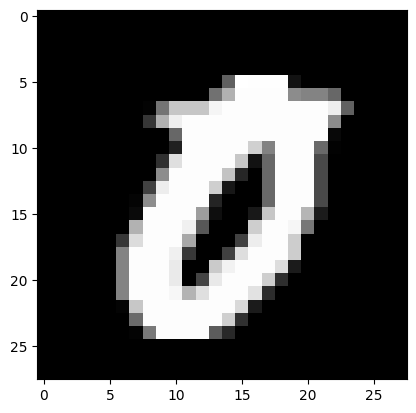

Prediction:  [6]
Label:  [6]


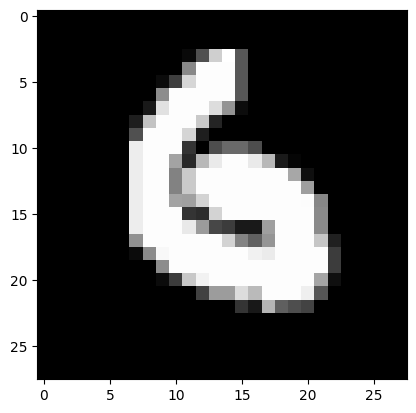

In [ ]:
# Some Predictions VS Labels
import random
for i in random.sample(range(1, 10000), 5):
    ann.test_prediction(i, X_test, Y_test)